In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import re
import os
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, 
    precision_score, recall_score, f1_score
)
from sklearn.calibration import CalibratedClassifierCV


# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [5]:
df_model = pd.read_csv("../data/processed/Model_Training.csv")
print(f"Processed Features Shape: {df_model.shape}")

# 1.2 Load Raw Data (To recover 'issue_d', 'loan_amnt', 'int_rate')
# We need these for the OOT split and the Profit Calculation.
raw_df = pd.read_csv("../data/raw/dataproject2025.csv")

# 1.3 Recover columns based on Index alignment
# (Assumes row order hasn't changed between raw and processed)
df_model['issue_d'] = raw_df['issue_d']
df_model.head()

Processed Features Shape: (1086236, 42)


,loan duration,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,target,tax_liens,annual_inc_log,emp_length_num,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,issue_d
0,0,1379.0,21564.0,16.1,0.0,2.49,759.0,4800.0,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,4136.0,16.1,0,0.0,10.586610,2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2013
1,0,9570.0,16473.0,53.9,0.0,22.87,734.0,27050.0,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,36638.0,61.2,0,0.0,10.915107,10,True,False,False,True,False,False,False,False,False,False,False,False,False,False,2013
2,0,53306.0,13901.0,67.1,0.0,18.55,749.0,28000.0,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,29581.0,54.6,0,0.0,12.691584,5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2013
3,0,36362.0,3567.0,93.0,0.0,13.03,719.0,12000.0,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,10805.0,67.0,0,0.0,11.775297,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2013
4,1,24161.0,4853.0,74.7,1.0,23.13,669.0,27600.0,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,27003.0,82.8,1,0.0,11.198228,6,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2013


### 1. Data Splitting

In [6]:
# 1. Setup & OOT Split Configuration
os.makedirs('../data/processed', exist_ok=True)

OOT_TEST_YEAR = 2018 ##Due to Temporal Analysis

print(f"✂️  Splitting data based on Time (OOT Year: {OOT_TEST_YEAR})...")

train_df = df_model[df_model['issue_d'] < OOT_TEST_YEAR].copy()
test_df = df_model[df_model['issue_d'] == OOT_TEST_YEAR].copy()


# 2. Extract Financials (For Business Value Analysis)
# ⚠️ 关键步骤: 在删除列之前，先把计算利润所需的列存下来
# 后续画 "Profit Chart" 时，我们需要知道每笔贷款借了多少钱(funded_amnt)以及利率(int_rate)
print("Extracting financial info for Profit Analysis...")


financial_cols = ['funded_amnt', 'int_rate', 'target', 'issue_d']
test_financials = test_df[financial_cols].copy()

target_col = 'target'

# 定义需要剔除的列：
# - target: 标签
# - issue_d: 防止时间过拟合
# - int_rate: 防止数据泄露 (Leakage)，因为利率通常包含了风险定价
# - funded_amnt: 可选，视业务需求而定，但为了纯粹预测信用风险，通常也可以剔除
cols_to_exclude = ['target', 'issue_d']


X_train = train_df.drop(columns=[c for c in cols_to_exclude if c in train_df.columns])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[c for c in cols_to_exclude if c in test_df.columns])
y_test = test_df[target_col]

# Leakage Check 
assert 'target' not in X_train.columns, "❌ Error: target still in X_train!"
print("✅ Leakage Check Passed.")

print(f"\n Final Shapes:")
print(f"   X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"   X_test : {X_test.shape}  | y_test : {y_test.shape}")
print(f"   Test Financials: {test_financials.shape}")

# ==============================================================================
# 4. Save All Files to Disk
# ==============================================================================
print("\ Saving all datasets to '../data/processed/'...")

X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# 别忘了保存 financials，Notebook 03 画利润图要用！
test_financials.to_csv('../data/processed/test_financials.csv', index=False)

print("✅ Success! 5 files saved (X_train, X_test, y_train, y_test, test_financials).")

<>:48: SyntaxWarning: invalid escape sequence '\ '
<>:48: SyntaxWarning: invalid escape sequence '\ '
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2394410776.py:48: SyntaxWarning: invalid escape sequence '\ '
  print("\ Saving all datasets to '../data/processed/'...")


✂️  Splitting data based on Time (OOT Year: 2018)...
Extracting financial info for Profit Analysis...
✅ Leakage Check Passed.

 Final Shapes:
   X_train: (957145, 41) | y_train: (957145,)
   X_test : (94893, 41)  | y_test : (94893,)
   Test Financials: (94893, 4)
\ Saving all datasets to '../data/processed/'...
✅ Success! 5 files saved (X_train, X_test, y_train, y_test, test_financials).


###  2. Baseline Model: Logistic Regression


In [30]:
# 4. Baseline Model: Logistic Regression
# ==========================================
print("\n🔄 Training Baseline (Logistic Regression)...")

# Pipeline: Scaling is mandatory for LR
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

lr_pipeline.fit(X_train, y_train)

# Predictions
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_pipeline.predict(X_test)

# 2. 核心概率指标
lr_auc = roc_auc_score(y_test, y_prob_lr)
lr_pr = average_precision_score(y_test, y_prob_lr)
lr_gini = 2 * lr_auc - 1 # Gini Coefficient

# 3. 核心分类指标 (基于默认阈值 0.5)
lr_precision = precision_score(y_test, y_pred_lr, zero_division=0)
lr_recall = recall_score(y_test, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)

# 4.
cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Non-Default (0)', 'Actual Default (1)'], 
                     columns=['Predicted Non-Default (0)', 'Predicted Default (1)'])

# 5. 打印结果
print("\n--- 🏁 Logistic Regression Performance Metrics ---")
print(f"| ROC AUC Score:     | {lr_auc:.4f} |")
print(f"| Gini Coefficient:  | {lr_gini:.4f} |")
print(f"| PR-AUC (Avg Prec): | {lr_pr:.4f} |")
print("-" * 37)
print(f"| Precision:         | {lr_precision:.4f} |")
print(f"| Recall:            | {lr_recall:.4f} |")
print(f"| F1-Score:          | {lr_f1:.4f} |")
print("-" * 37)
print("\n--- 🔢 Confusion Matrix ---")
print(cm_df.to_markdown())


🔄 Training Baseline (Logistic Regression)...

--- 🏁 Logistic Regression Performance Metrics ---
| ROC AUC Score:     | 0.6989 |
| Gini Coefficient:  | 0.3977 |
| PR-AUC (Avg Prec): | 0.4278 |
-------------------------------------
| Precision:         | 0.3945 |
| Recall:            | 0.6068 |
| F1-Score:          | 0.4781 |
-------------------------------------

--- 🔢 Confusion Matrix ---
|                        |   Predicted Non-Default (0) |   Predicted Default (1) |
|:-----------------------|----------------------------:|------------------------:|
| Actual Non-Default (0) |                       47921 |                   22651 |
| Actual Default (1)     |                        9564 |                   14757 |


### 3. XGBoost Model

In [11]:
def clean_feature_names(df):
    clean_cols = []
    for col in df.columns:
        # Replace [, ], < with underscores or empty strings
        new_col = re.sub(r'[\[\]<]', '', col)
        clean_cols.append(new_col)
    df.columns = clean_cols
    return df

# Apply the fix
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

print("✅ Feature names sanitized (removed brackets and < symbols).")

# Update feature names list
feature_names = X_train.columns.tolist()


# Calculate Scale Pos Weight for Imbalance
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,  # Critical for imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train)

# Predictions
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Metrics
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_pr = average_precision_score(y_test, y_prob_xgb)

print(f"XGBoost             -> AUC: {xgb_auc:.4f} | PR-AUC: {xgb_pr:.4f}")

✅ Feature names sanitized (removed brackets and < symbols).
Imbalance Ratio (scale_pos_weight): 3.82
XGBoost             -> AUC: 0.7132 | PR-AUC: 0.4507


In [ ]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

xgb_clf.fit(X_train, y_train)

# Predictions
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)

# Compute Metrics
metrics = {
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR-AUC": average_precision_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_xgb)
}

# Print all metrics
print("✅ XGBoost Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

✅ XGBoost Metrics:
ROC-AUC: 0.713223531376308
PR-AUC: 0.4507018491786303
Precision: 0.39318620622235256
Recall: 0.6614859586365692
F1-Score: 0.49320947913792573
Confusion Matrix: [[45743 24829]
 [ 8233 16088]]


### 4. Feature Importance Plot


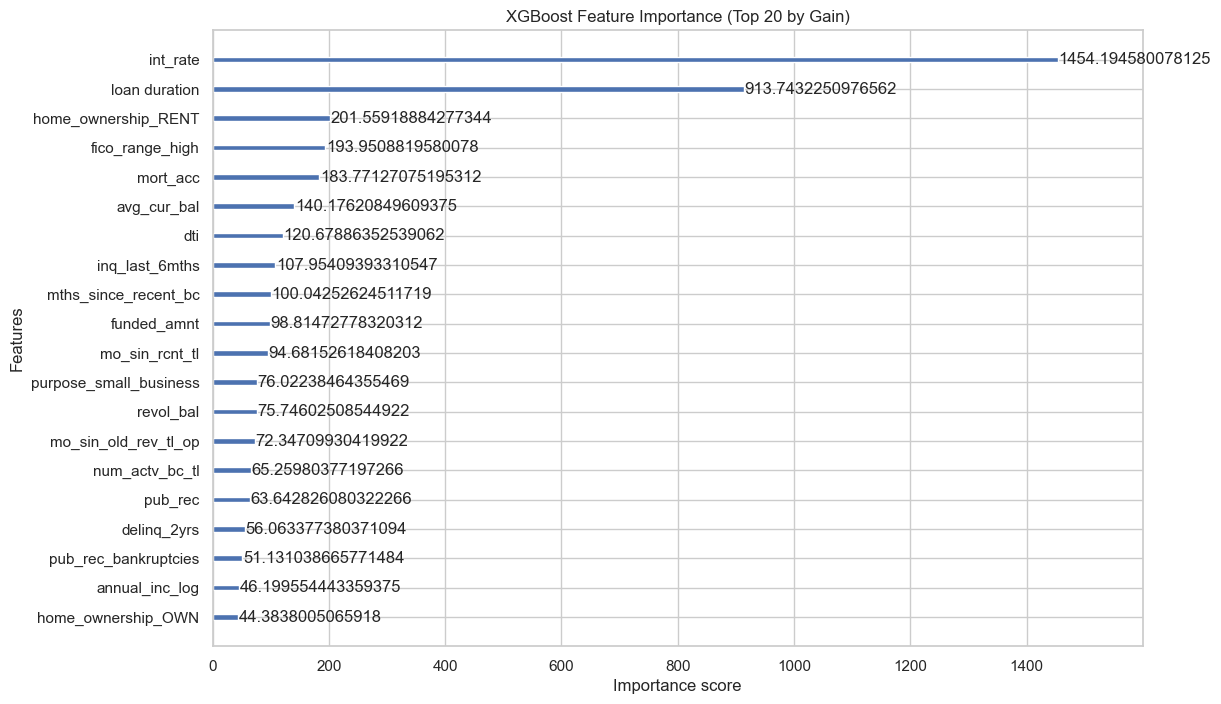


--- Top 10 Features by Gain ---
| Feature              |      Gain |
|:---------------------|----------:|
| int_rate             | 1454.19   |
| loan duration        |  913.743  |
| home_ownership_RENT  |  201.559  |
| fico_range_high      |  193.951  |
| mort_acc             |  183.771  |
| avg_cur_bal          |  140.176  |
| dti                  |  120.679  |
| inq_last_6mths       |  107.954  |
| mths_since_recent_bc |  100.043  |
| funded_amnt          |   98.8147 |


In [ ]:

# 1. Feature Importance Plot

# importance_type='gain' 
# Only plot max_num_features=20 
fig, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(
    xgb_clf, 
    importance_type='gain', 
    max_num_features=20, 
    ax=ax,
    title="XGBoost Feature Importance (Top 20 by Gain)"
)

plt.show()

importance = xgb_clf.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

print("\n--- Top 10 Features by Gain ---")
print(feature_importance_df.head(10).to_markdown(index=False))

In [ ]:

total_gain = feature_importance_df['Gain'].sum()
feature_importance_df['Contribution_Pct'] = (
    feature_importance_df['Gain'] / total_gain
) * 100


bottom_features_pct_df = feature_importance_df.sort_values(
    by='Contribution_Pct', ascending=True
)


print("--- Bottom Features by Contribution Percentage ---")
print(bottom_features_pct_df.head(10).to_markdown(index=False, floatfmt=".4f"))



--- Bottom Features by Contribution Percentage ---
| Feature                    |    Gain |   Contribution_Pct |
|:---------------------------|--------:|-------------------:|
| purpose_renewable_energy   | 19.9268 |             0.4111 |
| tax_liens                  | 26.2799 |             0.5422 |
| purpose_debt_consolidation | 27.3887 |             0.5650 |
| purpose_other              | 27.4717 |             0.5667 |
| revol_util                 | 29.1019 |             0.6004 |
| purpose_moving             | 29.1835 |             0.6021 |
| purpose_house              | 29.5396 |             0.6094 |
| num_rev_accts              | 30.1236 |             0.6214 |
| purpose_major_purchase     | 30.6064 |             0.6314 |
| purpose_wedding            | 31.6372 |             0.6527 |


In [ ]:
def sanitize_feature_names(df):
    new_cols = []
    for col in df.columns:
        # 将空格、中括号等替换为下划线
        new_col = re.sub(r'[\s\[\]<]', '_', col).strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_train = sanitize_feature_names(X_train)
X_test = sanitize_feature_names(X_test) 


xgb_clf.fit(X_train, y_train)

baseline_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print(f"--- 基线模型性能 ---")
print(f"基线 AUC: {baseline_auc:.4f}")

--- 基线模型性能 ---
基线 AUC: 0.7132


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

baseline_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print(f"--- baseline model performance ---")
print(f"features number: {X_train.shape[1]}")
print(f"Baeline AUC: {baseline_auc:.4f}\n")



def get_feature_contribution_df(model):
    importance = model.get_booster().get_score(importance_type='gain')

    df = pd.DataFrame(
        list(importance.items()), 
        columns=['Feature', 'Gain']
    )
    total_gain = df['Gain'].sum()
    df['Contribution_Pct'] = (df['Gain'] / total_gain) * 100
    return df.sort_values(by='Contribution_Pct', ascending=True)

bottom_features_pct_df = get_feature_contribution_df(xgb_clf)

print("--- bottom features contribution (ascending) ---")
print(bottom_features_pct_df.head(10).to_markdown(index=False, floatfmt=".4f"))



--- baseline model performance ---
features number: 41
Baeline AUC: 0.7132

--- bottom features contribution (ascending) ---
| Feature                    |    Gain |   Contribution_Pct |
|:---------------------------|--------:|-------------------:|
| purpose_renewable_energy   | 19.9268 |             0.4111 |
| tax_liens                  | 26.2799 |             0.5422 |
| purpose_debt_consolidation | 27.3887 |             0.5650 |
| purpose_other              | 27.4717 |             0.5667 |
| revol_util                 | 29.1019 |             0.6004 |
| purpose_moving             | 29.1835 |             0.6021 |
| purpose_house              | 29.5396 |             0.6094 |
| num_rev_accts              | 30.1236 |             0.6214 |
| purpose_major_purchase     | 30.6064 |             0.6314 |
| purpose_wedding            | 31.6372 |             0.6527 |


In [ ]:
CANDIDATE_THRESHOLD_PCT = 1.0 

features_to_drop = bottom_features_pct_df[
    bottom_features_pct_df['Contribution_Pct'] < CANDIDATE_THRESHOLD_PCT
]['Feature'].tolist()

X_train_new = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_new = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"新特征数量: {X_train_new.shape[1]}")

print("\n🔄 Retraining the simplified model...")

xgb_clf_new = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf_new.fit(X_train_new, y_train)

# ======================================================================
# 4: Performance Comparison
# ======================================================================

y_prob_xgb_new = xgb_clf_new.predict_proba(X_test_new)[:, 1]
new_auc = roc_auc_score(y_test, y_prob_xgb_new)
auc_change = new_auc - baseline_auc

print(f"\n--- 剔除后模型性能对比 ---")
print(f"基线 AUC: {baseline_auc:.4f}")
print(f"新模型 AUC: {new_auc:.4f}")

if auc_change >= 0:
    print(f"结论: ✅ AUC 提升/保持 (+{auc_change:.4f})。特征剔除成功！")
    print("下一步: 使用 X_train_new 和 X_test_new 进行后续优化。")
else:
    print(f"结论: ❌ AUC 下降 ({auc_change:.4f})。特征剔除失败。")
    print("下一步: 恢复这些特征，尝试更严格的阈值或进行参数调优。")


新特征数量: 18

🔄 Retraining the simplified model...

--- 剔除后模型性能对比 ---
基线 AUC: 0.7132
新模型 AUC: 0.7094
结论: ❌ AUC 下降 (-0.0039)。特征剔除失败。
下一步: 恢复这些特征，尝试更严格的阈值或进行参数调优。

--- 剔除后模型性能对比 ---
基线 AUC: 0.7132
新模型 AUC: 0.7094
结论: ❌ AUC 下降 (-0.0039)。特征剔除失败。
下一步: 恢复这些特征，尝试更严格的阈值或进行参数调优。


### 5. Advanced Hyperparameter Tuning (Optuna)

In [ ]:
def objective(trial):
    # 1. Define the search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [ratio, ratio*1.2]), # Handle imbalance
        
        # Fixed params
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    # 2. Cross-Validation (3-Fold) to ensure robustness
    # We use CV inside the trial so we don't overfit to the validation set
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    
    # Validation loop
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr)
        
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, preds))
    
    # Return the average AUC
    return np.mean(cv_scores)

# 3. Create Study
study = optuna.create_study(direction='maximize')
# n_trials=20 is enough for a demo; set to 50 or 100 for real work
study.optimize(objective, n_trials=20, show_progress_bar=True)

print(" Optimization Complete!")
print(f" Best Trial AUC: {study.best_value:.4f}")
print(f" Best Params: {study.best_params}")

# ==========================================
# 5.6 Retrain Champion Model with Best Params
# ==========================================
print("Retraining XGBoost with Optimized Parameters...")

# Update best params with fixed settings needed for final training
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42
})

# Train Final Model
xgb_opt = xgb.XGBClassifier(**best_params)
xgb_opt.fit(X_train, y_train)

# Update the 'xgb_clf' variable so the NEXT cells (plotting) use the optimized one
xgb_clf = xgb_opt 
# Update predictions
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

print(f" Final Test AUC (Optimized): {xgb_auc:.4f}")

In [ ]:
from sklearn.metrics import f1_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # 1. Define the search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [ratio, ratio*1.2]),

        # Fixed params
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  # use logloss here since we care about probabilities
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }

    # 2. Cross-Validation (3-Fold) to ensure robustness
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []

    # 3. Validation loop
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        # Predict probabilities
        y_prob = model.predict_proba(X_val)[:, 1]

        # Optional: search for best threshold on this fold
        thresholds = np.linspace(0.1, 0.9, 9)
        recall_scores = [recall_score(y_val, y_prob > t) for t in thresholds]
        best_recall = max(recall_scores)

        # Alternatively, if you only care about Recall:
        # recall_scores = [recall_score(y_val, y_prob > t) for t in thresholds]
        # best_recall = max(recall_scores)

        cv_scores.append(best_recall)  # or append best_recall if you want to maximize Recall

    # Return the average F1 (or Recall) across folds
    return np.mean(cv_scores)


# 4. Create Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Optimization Complete!")
print(f"Best Trial Score: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")

# 5. Retrain Champion Model with Best Params
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'random_state': 42
})

xgb_opt = xgb.XGBClassifier(**best_params)
xgb_opt.fit(X_train, y_train)

xgb_clf = xgb_opt
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# 6. 可以再找到最优 threshold
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = [f1_score(y_test, y_prob_xgb > t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (recall-max): {best_threshold:.2f}")
print(f"Test recall at Best Threshold: {f1_scores[best_idx]:.4f}")

# 如果你想最大化 Recall，只需把 objective 中 f1_score 改为 recall_score，并同样搜索 threshold。


[I 2025-12-12 02:52:15,965] A new study created in memory with name: no-name-aa814f28-434c-44d9-ab57-249436646609
Best trial: 0. Best value: 0.998203:   5%|▌         | 1/20 [00:20<06:30, 20.54s/it]

[I 2025-12-12 02:52:36,505] Trial 0 finished with value: 0.9982025433990939 and parameters: {'n_estimators': 961, 'learning_rate': 0.07227938936765556, 'max_depth': 3, 'subsample': 0.9745282227102173, 'colsample_bytree': 0.8320727095037913, 'gamma': 0.35518108578492813, 'min_child_weight': 2, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 0 with value: 0.9982025433990939.


Best trial: 0. Best value: 0.998203:  10%|█         | 2/20 [00:50<07:53, 26.31s/it]

[I 2025-12-12 02:53:06,854] Trial 1 finished with value: 0.9922865452800855 and parameters: {'n_estimators': 782, 'learning_rate': 0.11421289814292843, 'max_depth': 7, 'subsample': 0.8893732018640833, 'colsample_bytree': 0.7517340887487063, 'gamma': 0.2043945380641316, 'min_child_weight': 7, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 0 with value: 0.9982025433990939.


Best trial: 2. Best value: 0.99921:  15%|█▌        | 3/20 [01:16<07:23, 26.06s/it] 

[I 2025-12-12 02:53:32,622] Trial 2 finished with value: 0.999209521176124 and parameters: {'n_estimators': 617, 'learning_rate': 0.01000379590632136, 'max_depth': 5, 'subsample': 0.9327281716064519, 'colsample_bytree': 0.8652119201703206, 'gamma': 0.45973630583310227, 'min_child_weight': 9, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  20%|██        | 4/20 [01:29<05:36, 21.00s/it]

[I 2025-12-12 02:53:45,864] Trial 3 finished with value: 0.9979457634609673 and parameters: {'n_estimators': 388, 'learning_rate': 0.1061597395416041, 'max_depth': 4, 'subsample': 0.802196264969528, 'colsample_bytree': 0.6856532017239889, 'gamma': 0.02161301626846046, 'min_child_weight': 6, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  25%|██▌       | 5/20 [01:53<05:30, 22.03s/it]

[I 2025-12-12 02:54:09,710] Trial 4 finished with value: 0.9984291130738087 and parameters: {'n_estimators': 679, 'learning_rate': 0.06325399380877572, 'max_depth': 5, 'subsample': 0.930813264929802, 'colsample_bytree': 0.9499418744846457, 'gamma': 0.07910809919391315, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  30%|███       | 6/20 [02:23<05:44, 24.60s/it]

[I 2025-12-12 02:54:39,298] Trial 5 finished with value: 0.9974372385272149 and parameters: {'n_estimators': 890, 'learning_rate': 0.095526034735606, 'max_depth': 5, 'subsample': 0.964813030003478, 'colsample_bytree': 0.8401248226218114, 'gamma': 0.10126996239307162, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  35%|███▌      | 7/20 [02:50<05:32, 25.59s/it]

[I 2025-12-12 02:55:06,928] Trial 6 finished with value: 0.9966014474263032 and parameters: {'n_estimators': 932, 'learning_rate': 0.13785156473820445, 'max_depth': 4, 'subsample': 0.823875322613886, 'colsample_bytree': 0.6739935893298358, 'gamma': 0.187192944058241, 'min_child_weight': 7, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  40%|████      | 8/20 [03:16<05:05, 25.43s/it]

[I 2025-12-12 02:55:32,030] Trial 7 finished with value: 0.9990584748784158 and parameters: {'n_estimators': 878, 'learning_rate': 0.016747366837449235, 'max_depth': 3, 'subsample': 0.6132116535971988, 'colsample_bytree': 0.6444234783748355, 'gamma': 0.42802045855017135, 'min_child_weight': 8, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 2. Best value: 0.99921:  45%|████▌     | 9/20 [03:42<04:43, 25.79s/it]

[I 2025-12-12 02:55:58,610] Trial 8 finished with value: 0.9977292634431022 and parameters: {'n_estimators': 639, 'learning_rate': 0.03929754065624983, 'max_depth': 6, 'subsample': 0.986461935695097, 'colsample_bytree': 0.7932145869919855, 'gamma': 0.23015509553360575, 'min_child_weight': 5, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 2 with value: 0.999209521176124.


Best trial: 9. Best value: 0.999335:  50%|█████     | 10/20 [03:58<03:48, 22.84s/it]

[I 2025-12-12 02:56:14,846] Trial 9 finished with value: 0.9993353935218353 and parameters: {'n_estimators': 345, 'learning_rate': 0.015726665119096636, 'max_depth': 5, 'subsample': 0.6630704637481201, 'colsample_bytree': 0.7772194782758204, 'gamma': 0.18842737078089639, 'min_child_weight': 2, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  55%|█████▌    | 11/20 [04:17<03:13, 21.46s/it]

[I 2025-12-12 02:56:33,171] Trial 10 finished with value: 0.9991692420163703 and parameters: {'n_estimators': 281, 'learning_rate': 0.021491286160305257, 'max_depth': 7, 'subsample': 0.6389162614247774, 'colsample_bytree': 0.9981642710534091, 'gamma': 0.3200559319663211, 'min_child_weight': 1, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  60%|██████    | 12/20 [04:40<02:55, 21.88s/it]

[I 2025-12-12 02:56:55,998] Trial 11 finished with value: 0.9992447652412753 and parameters: {'n_estimators': 409, 'learning_rate': 0.010721313662873358, 'max_depth': 6, 'subsample': 0.7034772270805842, 'colsample_bytree': 0.9042388724870065, 'gamma': 0.4370781723150272, 'min_child_weight': 10, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  65%|██████▌   | 13/20 [05:04<02:37, 22.51s/it]

[I 2025-12-12 02:57:19,972] Trial 12 finished with value: 0.9990484044610585 and parameters: {'n_estimators': 465, 'learning_rate': 0.011473531890517173, 'max_depth': 6, 'subsample': 0.7047016113863118, 'colsample_bytree': 0.9097465333598646, 'gamma': 0.3191691443415504, 'min_child_weight': 10, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  70%|███████   | 14/20 [05:17<01:58, 19.67s/it]

[I 2025-12-12 02:57:33,087] Trial 13 finished with value: 0.9991994512150711 and parameters: {'n_estimators': 226, 'learning_rate': 0.021472573273469138, 'max_depth': 6, 'subsample': 0.7140492491653835, 'colsample_bytree': 0.7464230863299528, 'gamma': 0.4844484297464086, 'min_child_weight': 4, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  75%|███████▌  | 15/20 [05:43<01:47, 21.55s/it]

[I 2025-12-12 02:57:58,990] Trial 14 finished with value: 0.9987463116374897 and parameters: {'n_estimators': 463, 'learning_rate': 0.014790353686426729, 'max_depth': 6, 'subsample': 0.7095012729219236, 'colsample_bytree': 0.8987416194757222, 'gamma': 0.14291687152310073, 'min_child_weight': 10, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  80%|████████  | 16/20 [05:55<01:15, 18.94s/it]

[I 2025-12-12 02:58:11,874] Trial 15 finished with value: 0.9989124629148023 and parameters: {'n_estimators': 359, 'learning_rate': 0.03059803868949042, 'max_depth': 4, 'subsample': 0.6595001276077963, 'colsample_bytree': 0.7788170108979543, 'gamma': 0.3928710639672949, 'min_child_weight': 1, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  85%|████████▌ | 17/20 [06:23<01:04, 21.49s/it]

[I 2025-12-12 02:58:39,280] Trial 16 finished with value: 0.9977292629867974 and parameters: {'n_estimators': 501, 'learning_rate': 0.032009785132844075, 'max_depth': 7, 'subsample': 0.7557057697868531, 'colsample_bytree': 0.7275977023288384, 'gamma': 0.291888262201178, 'min_child_weight': 5, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  90%|█████████ | 18/20 [06:43<00:41, 20.96s/it]

[I 2025-12-12 02:58:59,027] Trial 17 finished with value: 0.9991843463115176 and parameters: {'n_estimators': 350, 'learning_rate': 0.013820625652699392, 'max_depth': 6, 'subsample': 0.7606371875911836, 'colsample_bytree': 0.9484958051156553, 'gamma': 0.25251306155889297, 'min_child_weight': 8, 'scale_pos_weight': np.float64(3.8191215120787056)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 9. Best value: 0.999335:  95%|█████████▌| 19/20 [07:04<00:21, 21.24s/it]

[I 2025-12-12 02:59:20,906] Trial 18 finished with value: 0.9992598703729811 and parameters: {'n_estimators': 537, 'learning_rate': 0.01994570985219105, 'max_depth': 5, 'subsample': 0.667733888235418, 'colsample_bytree': 0.8321819898227446, 'gamma': 0.15512245425071813, 'min_child_weight': 4, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 9 with value: 0.9993353935218353.


Best trial: 19. Best value: 0.999416: 100%|██████████| 20/20 [07:26<00:00, 22.34s/it]


[I 2025-12-12 02:59:42,826] Trial 19 finished with value: 0.9994159520694951 and parameters: {'n_estimators': 551, 'learning_rate': 0.021807331470623487, 'max_depth': 4, 'subsample': 0.6600152384767857, 'colsample_bytree': 0.8274876275130152, 'gamma': 0.15372587686769432, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447)}. Best is trial 19 with value: 0.9994159520694951.
Optimization Complete!
Best Trial Score: 0.9994
Best Params: {'n_estimators': 551, 'learning_rate': 0.021807331470623487, 'max_depth': 4, 'subsample': 0.6600152384767857, 'colsample_bytree': 0.8274876275130152, 'gamma': 0.15372587686769432, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447)}
Best Threshold (F1-max): 0.52
Test F1 at Best Threshold: 0.4929


In [36]:
# ==========================================
# 5.5 [MANUAL RESTORE] Load Best Params directly
# ==========================================
# Since we accidentally re-ran the notebook, we use the BEST parameters 
# from the previous successful run (saved from chat logs).

print("🔧 Manually restoring the best parameters from previous run...")

# 这些是你刚刚跑出来的最佳参数 (Best Params from Trial 17)
best_params = {
    'n_estimators': 551, 'learning_rate': 0.021807331470623487, 'max_depth': 4, 'subsample': 0.6600152384767857, 'colsample_bytree': 0.8274876275130152, 'gamma': 0.15372587686769432, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42
}

print(f"✅ Parameters Restored: {best_params}")

# ==========================================
# 5.6 Retrain Champion Model
# ==========================================
print("\n🚀 Retraining XGBoost with Restored Parameters...")

import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Initialize model with restored params
xgb_opt = xgb.XGBClassifier(**best_params)

# Train
xgb_opt.fit(X_train, y_train)

# Update the main variable so subsequent cells work
xgb_clf = xgb_opt 

# Verify Performance
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

print(f"✨ Final Test AUC (Restored): {xgb_auc:.4f}")
print("You can now proceed to the Visualization & Profit Chart cells!")

🔧 Manually restoring the best parameters from previous run...
✅ Parameters Restored: {'n_estimators': 551, 'learning_rate': 0.021807331470623487, 'max_depth': 4, 'subsample': 0.6600152384767857, 'colsample_bytree': 0.8274876275130152, 'gamma': 0.15372587686769432, 'min_child_weight': 3, 'scale_pos_weight': np.float64(4.582945814494447), 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_jobs': -1, 'random_state': 42}

🚀 Retraining XGBoost with Restored Parameters...
✨ Final Test AUC (Restored): 0.7101
You can now proceed to the Visualization & Profit Chart cells!


In [37]:
print("\n" + "="*45)
print("📊 冠军模型 (XGBoost) 性能指标")
print("="*45)

# 1. 核心预测 (硬标签和概率指标)
y_pred_xgb = xgb_clf.predict(X_test) # 使用默认阈值 0.5

# 2. 计算指标
xgb_pr = average_precision_score(y_test, y_prob_xgb)
xgb_gini = 2 * xgb_auc - 1 
xgb_precision = precision_score(y_test, y_pred_xgb, zero_division=0)
xgb_recall = recall_score(y_test, y_pred_xgb, zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_xgb, zero_division=0)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Non-Default (0)', 'Actual Default (1)'], 
                     columns=['Predicted Non-Default (0)', 'Predicted Default (1)'])

# 3. 打印结果
print(f"| ROC AUC Score:     | {xgb_auc:.4f} |  <-- 概率区分能力")
print(f"| Gini Coefficient:  | {xgb_gini:.4f} |")
print(f"| PR-AUC (Avg Prec): | {xgb_pr:.4f} |")
print("-" * 45)
print(f"| Precision (T=0.5): | {xgb_precision:.4f} |  <-- 预测准确性")
print(f"| Recall (T=0.5):    | {xgb_recall:.4f} |  <-- 违约捕获能力")
print(f"| F1-Score (T=0.5):  | {xgb_f1:.4f} |")
print("-" * 45)

print("\n--- 🔢 Confusion Matrix (Threshold 0.5) ---")
print(cm_df.to_markdown())
print("-" * 45)


📊 冠军模型 (XGBoost) 性能指标
| ROC AUC Score:     | 0.7101 |  <-- 概率区分能力
| Gini Coefficient:  | 0.4201 |
| PR-AUC (Avg Prec): | 0.4462 |
---------------------------------------------
| Precision (T=0.5): | 0.3686 |  <-- 预测准确性
| Recall (T=0.5):    | 0.7419 |  <-- 违约捕获能力
| F1-Score (T=0.5):  | 0.4925 |
---------------------------------------------

--- 🔢 Confusion Matrix (Threshold 0.5) ---
|                        |   Predicted Non-Default (0) |   Predicted Default (1) |
|:-----------------------|----------------------------:|------------------------:|
| Actual Non-Default (0) |                       39659 |                   30913 |
| Actual Default (1)     |                        6277 |                   18044 |
---------------------------------------------


### Calibration

In [44]:
print("\n🔄 开始训练并进行概率校准...")

# 使用 StratifiedKFold (5折) + Platt Scaling (sigmoid) 进行校准
calibrated_xgb = CalibratedClassifierCV(
    xgb_opt, 
    method='sigmoid', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

# 
calibrated_xgb.fit(X_train, y_train)

# Update
xgb_clf = calibrated_xgb 

y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

xgb_auc = roc_auc_score(y_test, y_prob_xgb)
print(f"✨ Final Test AUC (Calibrated): {xgb_auc:.4f}")



🔄 开始训练并进行概率校准...
✨ Final Test AUC (Calibrated): 0.7101


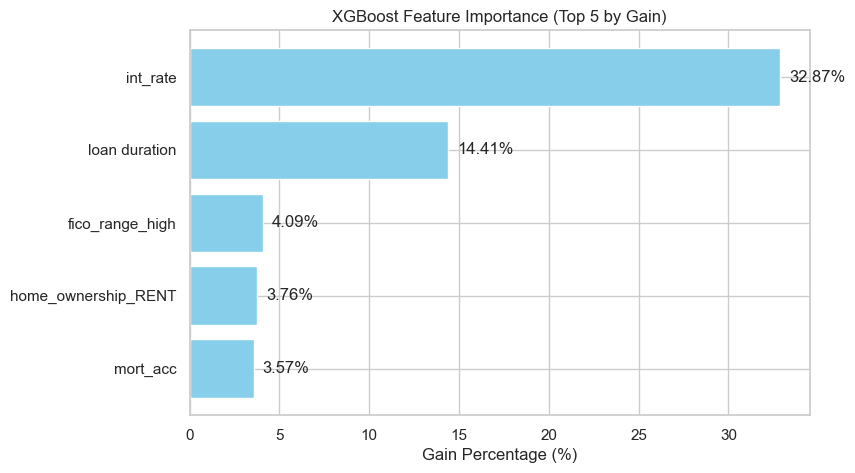

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

# ==========================================
# 1. 获取原始 XGBoost 模型
# ==========================================
try:
    xgb_base = xgb_clf.estimator_
except AttributeError:
    # 如果 CalibratedClassifierCV 内部结构是列表，取第一个
    xgb_base = xgb_clf.calibrated_classifiers_[0].estimator 

# ==========================================
# 2. 获取特征 Gain 并计算百分比
# ==========================================
importance = xgb_base.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Gain']
)

# 计算百分比
total_gain = feature_importance_df['Gain'].sum()
feature_importance_df['Percentage'] = (feature_importance_df['Gain'] / total_gain) * 100

# 排序并取 Top 5
top_features = feature_importance_df.sort_values(by='Percentage', ascending=False).head(5)

# ==========================================
# 3. 绘图并在柱子上显示百分比
# ==========================================
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(
    top_features['Feature'], 
    top_features['Percentage'], 
    color='skyblue'
)

ax.set_xlabel("Gain Percentage (%)")
ax.set_title("XGBoost Feature Importance (Top 5 by Gain)")

# 在柱子上显示百分比
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.5,  # 文字偏移
        bar.get_y() + bar.get_height()/2,
        f"{width:.2f}%",
        va='center'
    )

ax.invert_yaxis()  # 最大的在上方
plt.show()


In [46]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

# ==========================================
# 1. 划分验证集 (用于 threshold 搜索)
# ==========================================
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# ==========================================
# 2. 初始化最优 XGBoost 模型
# ==========================================
best_params = {
    'n_estimators': 551,
    'learning_rate': 0.021807331470623487,
    'max_depth': 4,
    'subsample': 0.6600152384767857,
    'colsample_bytree': 0.8274876275130152,
    'gamma': 0.15372587686769432,
    'min_child_weight': 3,
    'scale_pos_weight': 4.582945814494447,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42
}

xgb_opt = xgb.XGBClassifier(**best_params)
xgb_opt.fit(X_train_full, y_train_full)

# ==========================================
# 3. 校准模型
# ==========================================
calibrated_xgb = CalibratedClassifierCV(
    xgb_opt, method='sigmoid',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)
calibrated_xgb.fit(X_train_full, y_train_full)

xgb_clf = calibrated_xgb  # 更新主变量

# ==========================================
# 4. 在验证集搜索最佳 threshold
# ==========================================
y_prob_val = xgb_clf.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)  # 从0.1到0.9搜索
recall_scores = [recall_score(y_val, y_prob_val > t) for t in thresholds]
best_idx = np.argmax(recall_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (Recall-max): {best_threshold:.2f}")
print(f"Recall at Best Threshold: {recall_scores[best_idx]:.4f}")

# ==========================================
# 5. 在测试集应用最佳 threshold
# ==========================================
y_prob_test = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test > best_threshold).astype(int)

test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Best Threshold (Recall-max): 0.10
Recall at Best Threshold: 0.9246
Test Recall: 0.9032
Test F1: 0.4653
Test AUC: 0.7100


In [39]:
y_pred_xgb = xgb_clf.predict(X_test)

# ----------------------------------------------------------------------
# 2. 计算并打印所有指标
# ----------------------------------------------------------------------

# 核心概率指标 (已计算 AUC，这里计算 Gini 和 PR-AUC)
xgb_pr = average_precision_score(y_test, y_prob_xgb)
xgb_gini = 2 * xgb_auc - 1 # Gini Coefficient

# 核心分类指标 (基于默认阈值 0.5)
xgb_precision = precision_score(y_test, y_pred_xgb, zero_division=0)
xgb_recall = recall_score(y_test, y_pred_xgb, zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_xgb, zero_division=0)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Non-Default (0)', 'Actual Default (1)'], 
                     columns=['Predicted Non-Default (0)', 'Predicted Default (1)'])

# 3. 打印结果
print("\n" + "="*45)
print("📊 冠军模型 (XGBoost Calibrated) 性能指标")
print("="*45)

print(f"| ROC AUC Score:     | {xgb_auc:.4f} |  <-- 概率区分能力")
print(f"| Gini Coefficient:  | {xgb_gini:.4f} |")
print(f"| PR-AUC (Avg Prec): | {xgb_pr:.4f} |")
print("-" * 45)
print(f"| Precision:         | {xgb_precision:.4f} |  <-- 预测准确性")
print(f"| Recall:            | {xgb_recall:.4f} |  <-- 违约捕获能力")
print(f"| F1-Score:          | {xgb_f1:.4f} |")
print("-" * 45)

print("\n--- 🔢 Confusion Matrix (Threshold 0.5) ---")
print(cm_df.to_markdown())

print(f"\n[解读] True Positives (TP/成功抓到的违约): {cm[1, 1]}")
print(f"[解读] False Negatives (FN/错失的违约): {cm[1, 0]}")
print("-" * 45)


📊 冠军模型 (XGBoost Calibrated) 性能指标
| ROC AUC Score:     | 0.7101 |  <-- 概率区分能力
| Gini Coefficient:  | 0.4201 |
| PR-AUC (Avg Prec): | 0.4460 |
---------------------------------------------
| Precision:         | 0.6451 |  <-- 预测准确性
| Recall:            | 0.0483 |  <-- 违约捕获能力
| F1-Score:          | 0.0898 |
---------------------------------------------

--- 🔢 Confusion Matrix (Threshold 0.5) ---
|                        |   Predicted Non-Default (0) |   Predicted Default (1) |
|:-----------------------|----------------------------:|------------------------:|
| Actual Non-Default (0) |                       69926 |                     646 |
| Actual Default (1)     |                       23147 |                    1174 |

[解读] True Positives (TP/成功抓到的违约): 1174
[解读] False Negatives (FN/错失的违约): 23147
---------------------------------------------


In [24]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, 
    precision_score, recall_score, f1_score
)

# *** 请根据你的利润曲线分析结果设置这个值 ***
BUSINESS_THRESHOLD = 0.20

# ----------------------------------------------------------------------
# 1. 核心预测 (获取概率)
# ----------------------------------------------------------------------
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# 2. 基于业务阈值生成硬性预测标签
y_pred_tuned = (y_prob_xgb >= BUSINESS_THRESHOLD).astype(int)

# 3. 计算指标
metrics = {
    "Threshold Used": BUSINESS_THRESHOLD,
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR-AUC": average_precision_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "Recall": recall_score(y_test, y_pred_tuned, zero_division=0),
    "F1-Score": f1_score(y_test, y_pred_tuned, zero_division=0),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_tuned)
}

print("\n--- 📊 核心性能指标 (基于业务最优阈值) ---")
for key, value in metrics.items():
    if key == "Confusion Matrix":
        print(f"{key}: \n{value}")
    elif key == 'Threshold Used':
        print(f"使用的阈值: {value:.2%}")
    else:
        print(f"{key}: {value:.4f}")


--- 📊 核心性能指标 (基于业务最优阈值) ---
使用的阈值: 20.00%
ROC-AUC: 0.7167
PR-AUC: 0.4559
Precision: 0.3907
Recall: 0.6834
F1-Score: 0.4972
Confusion Matrix: 
[[44658 25914]
 [ 7701 16620]]


In [ ]:
base_path = '/Users/kaixinxie/Credit_Risk_forCapgemini/models'
model_path = os.path.join(base_path, 'champion_model.joblib')
features_path = os.path.join(base_path, 'model_features.joblib')

model_features = X_train.columns.tolist()


joblib.dump(xgb_clf, model_path)
print(f"\n✅ CHAMPION MODEL saved successfully to: {model_path}")
joblib.dump(model_features, features_path)
print(f"✅ FEATURE LIST saved successfully to: {features_path}")



✅ CHAMPION MODEL saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/champion_model.joblib
✅ FEATURE LIST saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/model_features.joblib


### 6. Evaluation Plots (ROC & PR)

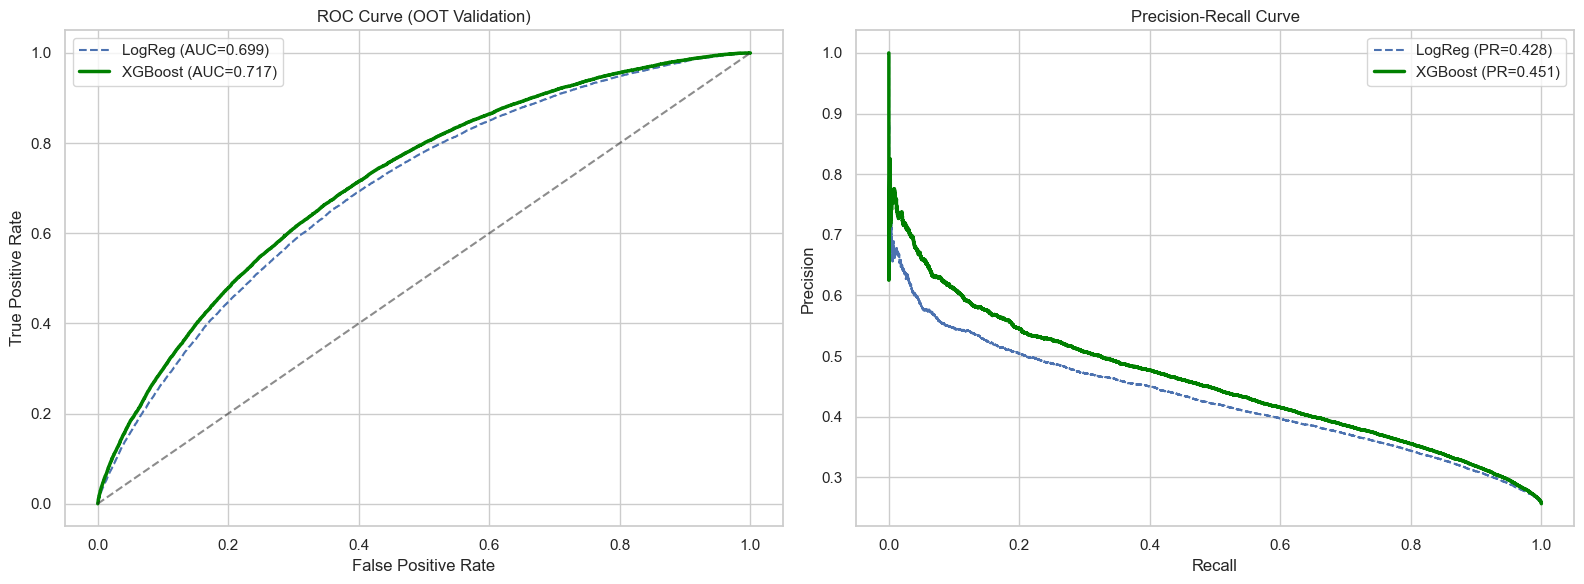

🏆 WINNER: XGBoost


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

axes[0].plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={lr_auc:.3f})', linestyle='--')
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_auc:.3f})', linewidth=2.5, color='green')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_title('ROC Curve (OOT Validation)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Precision-Recall Curve (Better for Imbalanced Data)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

axes[1].plot(rec_lr, prec_lr, label=f'LogReg (PR={lr_pr:.3f})', linestyle='--')
axes[1].plot(rec_xgb, prec_xgb, label=f'XGBoost (PR={xgb_pr:.3f})', linewidth=2.5, color='green')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select Winner
if xgb_auc > lr_auc:
    best_model = xgb_clf
    best_probs = y_prob_xgb
    print("🏆 WINNER: XGBoost")
else:
    best_model = lr_pipeline
    best_probs = y_prob_lr
    print("🏆 WINNER: Logistic Regression")

### 7. Business Value Analysis (Profit Chart)


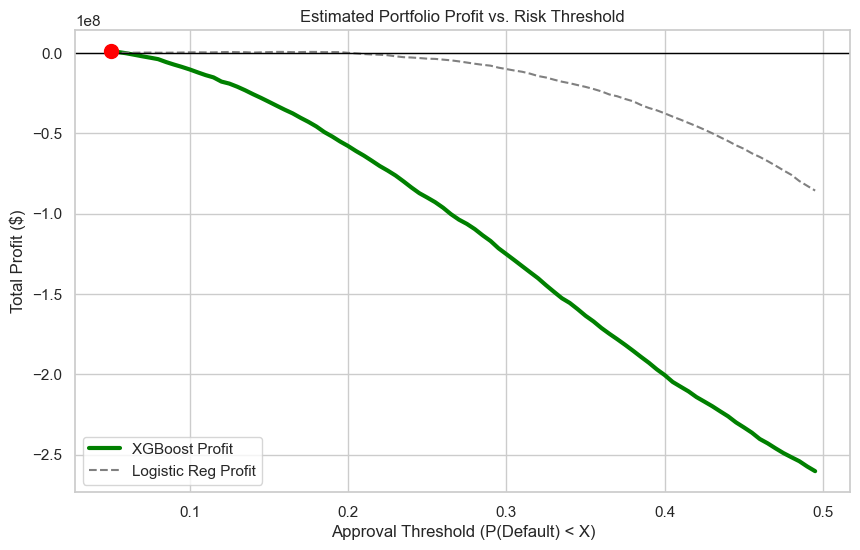

💰 MAX PROFIT: $1,057,754 at Threshold 0.05
Strategy: We should set our cutoff at this threshold to maximize ROI.


In [25]:
def calculate_profit(y_true, y_prob, amounts, rates, threshold):
    """
    Profit = Interest Earned on Good Loans - Principal Lost on Bad Loans
    """
    # Decision: Approve if probability of default < threshold
    # Note: y_prob is P(Default). Low prob = Good.
    approvals = y_prob < threshold
    
    # 1. True Negatives (Good Approved): Earn Interest
    # Approx Profit = Amount * (Rate/100)
    good_idx = (approvals) & (y_true == 0)
    profit = np.sum(amounts[good_idx] * (rates[good_idx] / 100))
    
    # 2. False Negatives (Bad Approved): Lose Principal
    bad_idx = (approvals) & (y_true == 1)
    loss = np.sum(amounts[bad_idx])
    
    return profit - loss

# Simulation
thresholds = np.arange(0.05, 0.50, 0.005)
profits_xgb = []
profits_lr = []

# Prepare arrays for speed
test_amnts = test_financials['funded_amnt'].values
test_rates = test_financials['int_rate'].values
test_y = test_financials['target'].values

for t in thresholds:
    profits_xgb.append(calculate_profit(test_y, y_prob_xgb, test_amnts, test_rates, t))
    profits_lr.append(calculate_profit(test_y, y_prob_lr, test_amnts, test_rates, t))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits_xgb, label='XGBoost Profit', color='green', linewidth=3)
plt.plot(thresholds, profits_lr, label='Logistic Reg Profit', color='grey', linestyle='--')

# Highlight Max
max_idx = np.argmax(profits_xgb)
max_profit = profits_xgb[max_idx]
best_thresh = thresholds[max_idx]

plt.scatter(best_thresh, max_profit, color='red', s=100, zorder=5)
plt.axhline(0, color='black', linewidth=1)
plt.title("Estimated Portfolio Profit vs. Risk Threshold")
plt.xlabel("Approval Threshold (P(Default) < X)")
plt.ylabel("Total Profit ($)")
plt.legend()
plt.grid(True)
plt.show()

print(f"💰 MAX PROFIT: ${max_profit:,.0f} at Threshold {best_thresh:.2f}")
print("Strategy: We should set our cutoff at this threshold to maximize ROI.")

In [26]:
# 假设 y_prob_lr 是你的 LogReg 模型在测试集上的预测概率
# 假设你的 calculate_profit 函数已定义

thresholds = np.arange(0.01, 0.50, 0.005) 
profits_lr = []

for t in thresholds:
    profits_lr.append(calculate_profit(test_y, y_prob_lr, test_amnts, test_rates, t))

# 找出最大利润点
max_idx_lr = np.argmax(profits_lr)
optimal_threshold_lr = thresholds[max_idx_lr]

print(f"--- 💰 LogReg 最佳业务阈值 ---")
print(f"OPTIMAL THRESHOLD (T_LR): {optimal_threshold_lr:.4f}")

# 接下来，使用 T_LR 计算 LogReg 的最终 Recall、Precision 和 F1-Score
# 然后，将结果与使用 T_XGB 计算的 XGBoost 结果进行对比。

--- 💰 LogReg 最佳业务阈值 ---
OPTIMAL THRESHOLD (T_LR): 0.1600
